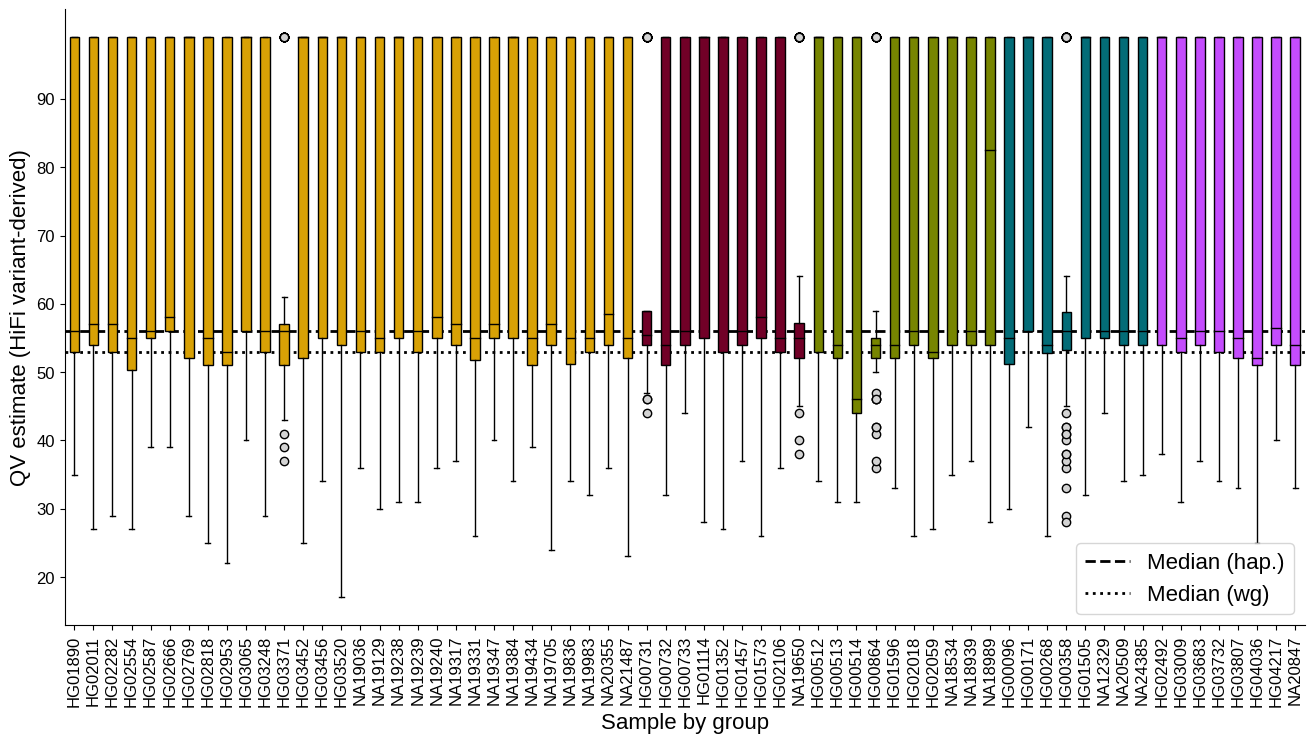

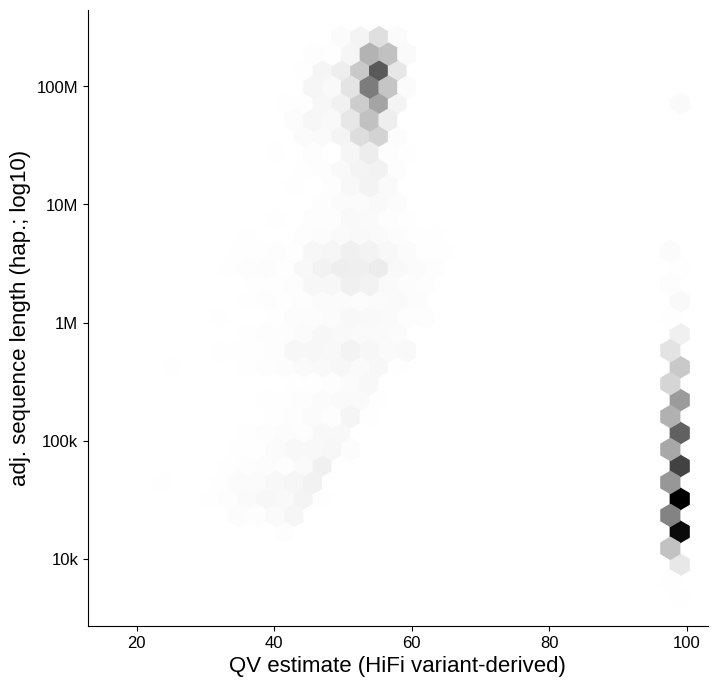

In [4]:
%run -n "../../00_project_config.ipynb"
%run -n "../../05_plot_config.ipynb"
%run -n "../../10_assm_stats.ipynb"

import numpy as np
import matplotlib.pyplot as plt

cache_qv_table = PROJECT_BASE.joinpath(
    "notebooks", ".cache", "qv_est_merged.tsv.gz"
)

data_source_folder = PROJECT_DATA_ROOT.joinpath(
    "2023_var_qv_est", "hgsvc"
)

aux_source_folder = PROJECT_DATA_ROOT.joinpath(
    "2024_tig_renaming", "untag_to_tag"
)
all_aux_files = list(aux_source_folder.glob("*.sed"))


def load_untag_to_tag_file(full_sample):
    
    one_file = [f for f in all_aux_files if full_sample in f.name]
    assert len(one_file) == 1
    tag_lut = dict()
    with open(one_file[0], "r") as listing:
        for line in listing:
            tig_name, tagged_name = line.split("/")[1:3]
            tag = tagged_name.rsplit(".", 1)[-1]
            if tag.startswith("haplo"):
                tag = f"hap{tag[-1]}"
            tag_lut[tig_name] = tag
    tag_lut["genome"] = "genome"
    return tag_lut


def read_qv_estimates(file_path):

    full_sample = file_path.name.split(".")
    full_sample = ".".join(full_sample[:2])
    tig_tags = load_untag_to_tag_file(full_sample)
    
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    df["sample"] = file_path.name.split(".")[0]
    df["asm_unit"] = df["seq_name"].replace(tig_tags)
    df = df.loc[df["asm_unit"].isin(["hap1", "hap2", "genome", "unassigned"]), :].copy()
    return df


def read_all_qv_estimates():
    
    merged = []
    for tsv in data_source_folder.glob("*tsv"):
        df = read_qv_estimates(tsv)
        merged.append(df)
    merged = pd.concat(merged, axis=0, ignore_index=False)
    return merged
    
qv_est = read_all_qv_estimates()
qv_est.to_csv(cache_qv_table, header=True, index=False, sep="\t")
qv_est = qv_est.set_index(["sample", "asm_unit"], inplace=False, drop=True)
qv_est.sort_index(inplace=True)

def plot_qv_est_boxplot(qv_est):
    
    boxes = []
    box_positions = []
    labels = []
    label_pos = []
    pos = 0
    box_colors = []
    hap_median = np.array([])
    wg_median = np.array([])
    for pop, sample in get_samples_ordered_by_pop():
        pos += 1
        h1_vals = qv_est.xs((sample, "hap1"))["qv"].values
        hap_median = np.concatenate((hap_median, h1_vals))
        
        h2_vals = qv_est.xs((sample, "hap2"))["qv"].values
        hap_median = np.concatenate((hap_median, h2_vals))
        
        wg_median = np.concatenate((wg_median, qv_est.xs((sample, "genome"))["qv"].values))
        
        boxes.append(np.concatenate((h1_vals, h2_vals)))
        box_positions.append(pos)
        box_colors.append(get_pop_color(sample))
        
        label_pos.append(pos)
        labels.append(sample)

    fig, ax = plt.subplots(figsize=(16,8))
    
    boxplot = ax.boxplot(
        boxes,
        positions=box_positions,
    )
    
    for patch, color in zip(boxplot["boxes"], box_colors):
        patch.set_facecolor(color)
        
    hap_median.sort()
    hap_median = hap_median[hap_median.size//2]
    ax.axhline(hap_median, 0, 1, ls="dashed", lw=2, color="black", zorder=0)
    
    wg_median.sort()
    wg_median = wg_median[wg_median.size//2]
    ax.axhline(wg_median, 0, 1, ls="dotted", lw=2, color="black", zorder=0)
        
    ax.set_xticks(label_pos)
    ax.set_xticklabels(labels, rotation=90)
    
    yticks = [20, 30, 40, 50, 60, 70, 80, 90]    
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)))
    
    legend_spec = [
        {
            "ls": "dashed",
            "lw": 2,
            "color": "black",
            "label": "Median (hap.)"
        },
        {
            "ls": "dotted",
            "lw": 2,
            "color": "black",
            "label": "Median (wg)"
        } 
    ]
    line_legend = get_line_legend(legend_spec)
    
    ax.legend(handles=line_legend, loc="best")
    
    ax.set_ylabel("QV estimate (HiFi variant-derived)")
    ax.set_xlabel("Sample by group")
    
    return None


def plot_qv_est_by_size(qv_est):
    
    qv_vals = np.array([])
    len_vals = np.array([])
    colors = []
    
    for pop, sample in get_samples_ordered_by_pop():
        
        for asm_unit in ["hap1", "hap2"]:

            qv = qv_est.xs((sample, asm_unit))["qv"].values
            lengths = qv_est.xs((sample, asm_unit))["adj_length"].values
            lengths = np.log10(lengths)
            qv_vals = np.concatenate((qv_vals, qv))
            len_vals = np.concatenate((len_vals, lengths))
            colors.extend([get_pop_color(sample)] * qv.size)

    fig, ax = plt.subplots(figsize=(8,8))
   
    ax.hexbin(
        qv_vals,
        len_vals,
        gridsize=30,
        cmap="binary"
    )
    
    ax.set_ylabel("adj. sequence length (hap.; log10)")
    yticks = [4, 5, 6, 7, 8]
    ax.set_yticks(yticks)
    yticklabels = ["10k", "100k", "1M", "10M", "100M"]
    ax.set_yticklabels(yticklabels)
    
    ax.set_xlabel("QV estimate (HiFi variant-derived)")
    
    return

_ = plot_qv_est_boxplot(qv_est)
_ = plot_qv_est_by_size(qv_est)